In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import csv

In [2]:
# load STREaM data (STREaM is a simulator of end-uses and water demand patterns)
# This dataset contains 3 years of hourly (26280 data points) synthetic demand data 
# for 4 user_classes = ['low','average','high','morning','night']. There are 500 user for each class,
# with the first 10 users having leaks. We need to remove these users for our purposes. 

# load data
all_data_path = './data/allData.txt'
df = pd.read_csv(all_data_path, header=None)

# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
# reverse df and change df columns
df = df.T
df.columns = headers

# remove first 10 of each class (these have leaks, so not useful for our purposes)
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

# echo
print(df.shape)

(26280, 1950)


In [3]:
# this function creates a hourly pattern of multipliers (up to 26280 hours long) mixing together n (max 1950) patterns
# from the STREaM dataset; it scales within a range (as expected for WNTR/EPANET input)
from sklearn.preprocessing import MinMaxScaler
def create_demand_pattern(df_patterns, n_hours=168, n_mix=50, bound = [0.3,0.9], noise_intensity=0.01):
    cols =df_patterns.columns.to_list()
    shuffle(cols)
    df_patterns = df_patterns[cols]
    s = MinMaxScaler(bound)
    temp=np.squeeze(s.fit_transform(df_patterns.iloc[:n_hours,:n_mix].mean(axis=1).values.reshape(-1,1)))
    dem_pat = temp + np.random.randn(n_hours)*noise_intensity
    return dem_pat

In [7]:
# modified (STREaM data)

# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
hours = 168*38

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names

# change duration of simulation
wn.options.time.duration=len(df_pat_new)*3600
    
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_new = sim.run_sim()

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


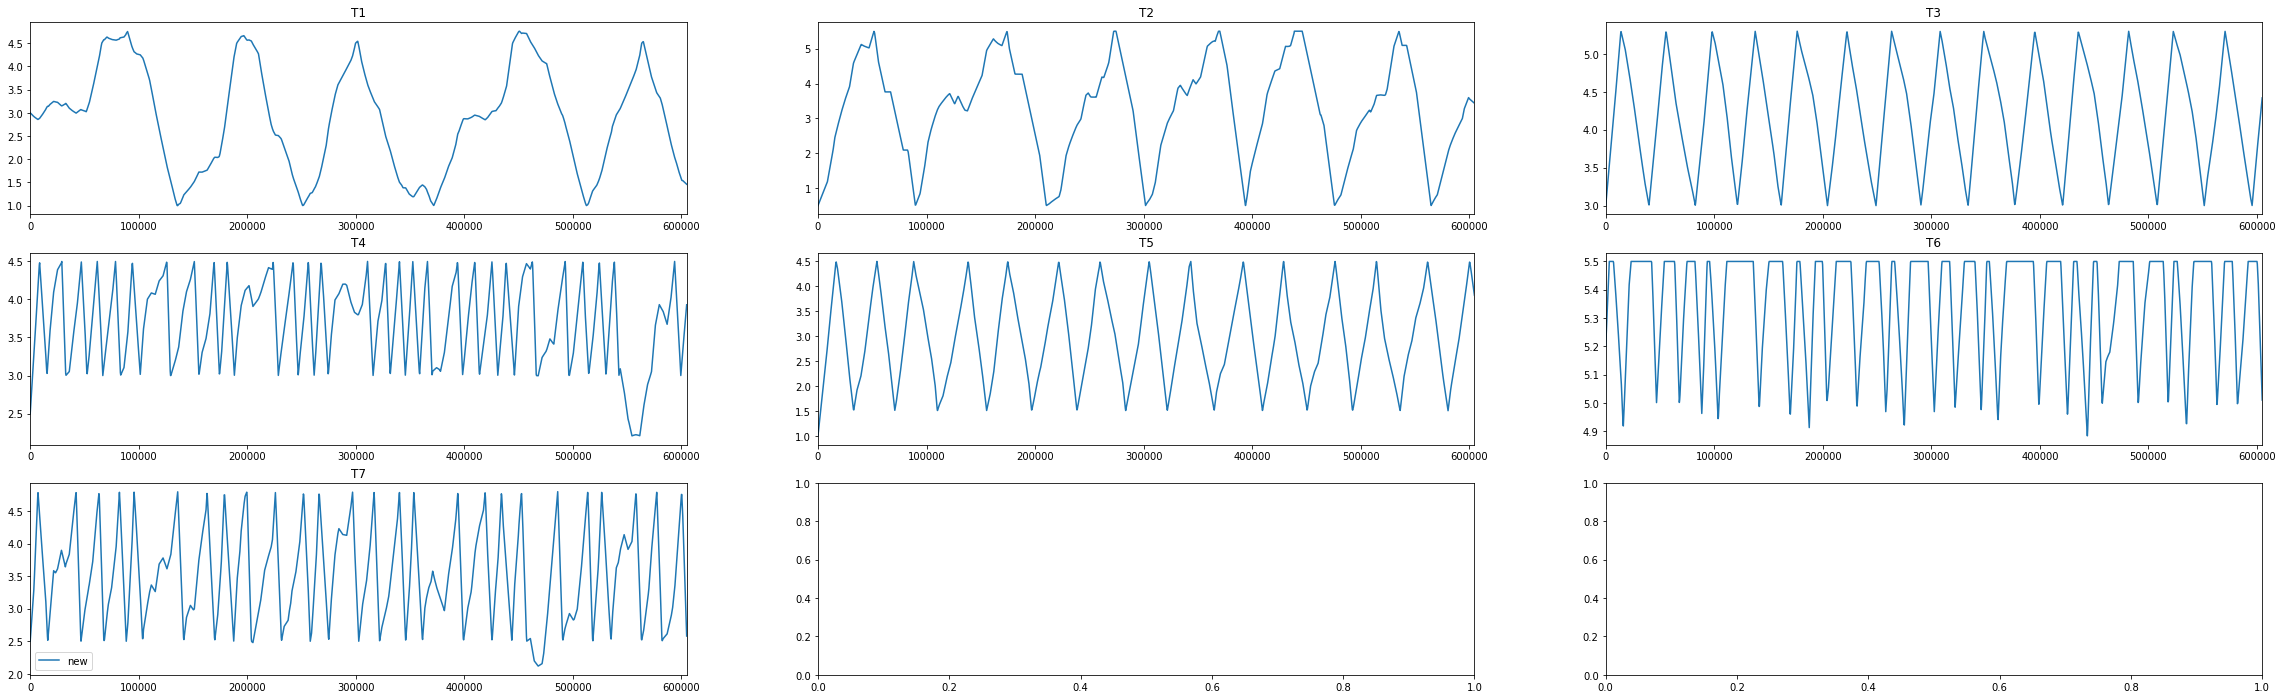

In [12]:
# compare tank levels
tank_names = [tank_name for tank_name, _ in wn.tanks()]
f, axes = plt.subplots(3,3,figsize=(40,12))
for tank_name, ax in zip(tank_names,axes.reshape(-1)):
    results_new.node['pressure'][tank_name].plot(label='new', ax=ax)
    ax.set_title(tank_name)
ax.legend()

In [3]:
# Controls the pattern length
week_length = 7 
day_length = 24
number_of_weeks = 38 # roughly, 9 months

# We store the patterns into a .csv file
output_path = 'enhanced_ctown_38_weeks.csv'

# Create a water network model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# We get all the junctions in the topology
node_list = list(wn.node_name_list)
junction_list  = []
for node in node_list:
    if wn.get_node(node).node_type == 'Junction':
        junction_list.append(str(node))
        
numbers_of_junctions = len(junction_list)        
df = pd.read_csv(all_data_path, header=None)

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [4]:
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results = sim.run_sim()

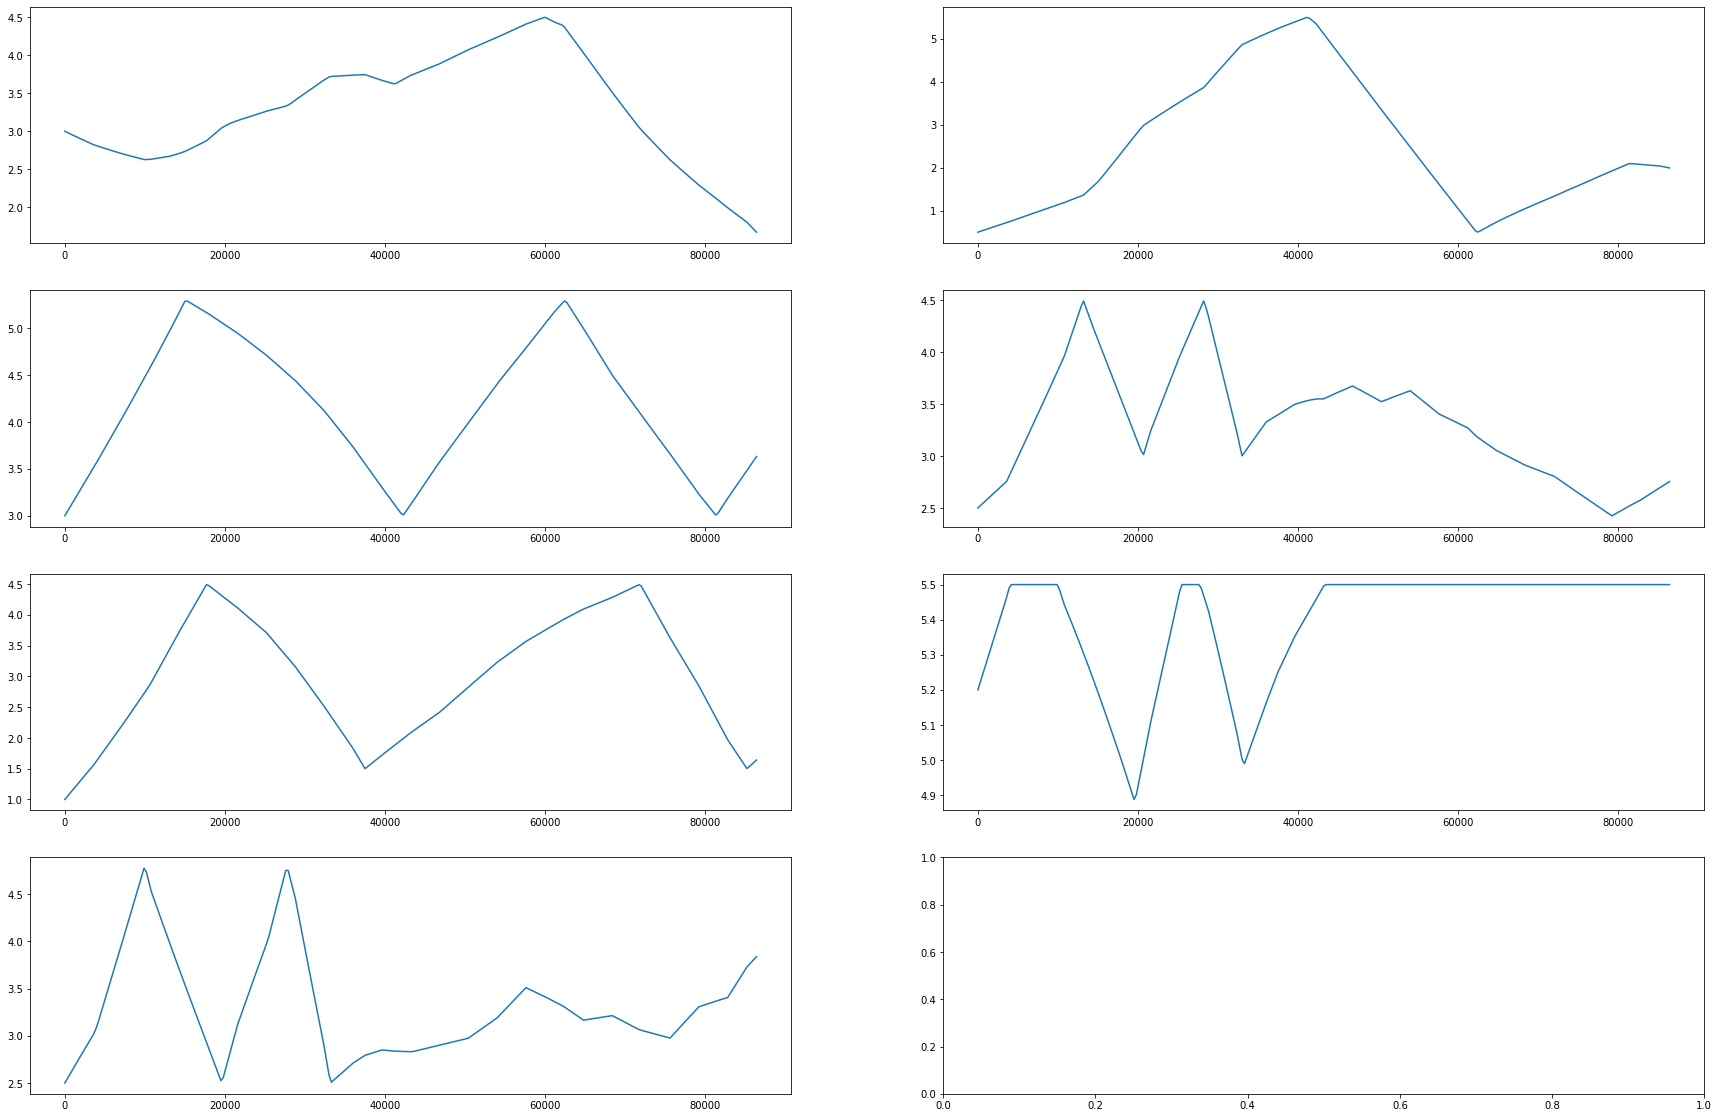

In [5]:
nr = 4
nc = 2
f, ax = plt.subplots(nr,nc,figsize=(30,20))
ax[0][0].plot(results.node['pressure']['T1'])
ax[0][1].plot(results.node['pressure']['T2'])
ax[1][0].plot(results.node['pressure']['T3'])
ax[1][1].plot(results.node['pressure']['T4'])
ax[2][0].plot(results.node['pressure']['T5'])
ax[2][1].plot(results.node['pressure']['T6'])
ax[3][0].plot(results.node['pressure']['T7'])

In [7]:
# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
# reverse df and change df columns
df = df.T
df.columns = headers

In [8]:
# remove first 10 of each class
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [9]:
#length of patterns
n_hours = day_length*week_length*number_of_weeks
# total number of nodes and get nodes for each type of users
n_nodes = 400 # original
composition = np.array([20,50,20,5,5])
assert(composition.sum()==100)
nodes_per_users = (composition/100*n_nodes).astype(int)
nodes_per_users[1]=nodes_per_users[1]+n_nodes-nodes_per_users.sum()
assert(nodes_per_users.sum()==n_nodes)
n_dict = dict((user, n_nodes) for (user, n_nodes) in zip(user_classes, nodes_per_users))

In [10]:
# ['node_%003d'%i for i in range(1,n_nodes+1)]
df_patterns = pd.DataFrame(index=range(n_hours))
for user_class in user_classes:
    these_cols = [col for col in headers if user_class in col]
    these_nodes = n_dict[user_class]
    df_patterns = pd.concat([df_patterns,df[these_cols].sample(these_nodes, axis=1).iloc[:n_hours, :]], axis=1)

In [11]:
pat_name = []
for i in range(1,334+1):
    pat_name.append('pat' + str(i))

In [12]:
cols =df_patterns.columns.to_list()
shuffle(cols)
df_patterns = df_patterns[cols]
dff = pd.DataFrame(index=df_patterns.index,columns=pat_name)

In [13]:
for i in range(0,84):
    dff['pat' + str( (i*4)+1)]=df_patterns.iloc[:,:100].sum(axis=1)
    dff['pat' + str( (i*4)+2)]=df_patterns.iloc[:,100:200].sum(axis=1)
    dff['pat' + str( (i*4)+3)]=df_patterns.iloc[:,200:300].sum(axis=1)
    dff['pat' + str( (i*4)+4)]=df_patterns.iloc[:,300:400].sum(axis=1)

In [14]:
del dff['pat335']
del dff['pat336']

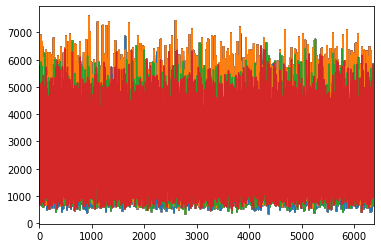

In [15]:
dff.plot(legend=None)

In [16]:
# Write the resulting patterns
dff.to_csv(output_path)

In [17]:
# Plot original pattern
df_old = wntr_utils.get_demand_patterns_from_nodes(wn)

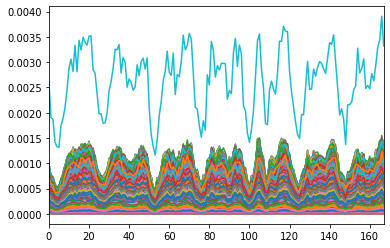

In [18]:
df_old.plot(legend=None)

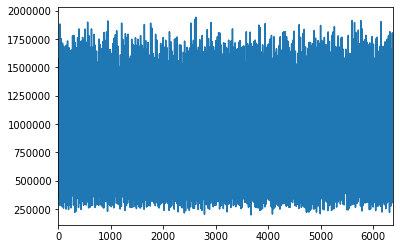

In [19]:
dff.sum(axis=1).plot()


<<< New Demands (top 5) >>>
pat276    4.160993
pat168    4.160993
pat96     4.160993
pat188    4.160993
pat256    4.160993
dtype: float64


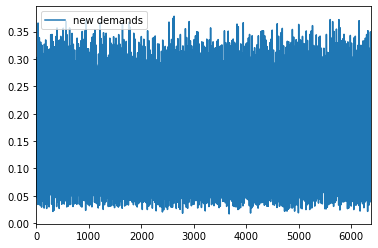

In [51]:
### load new demands
df_new = dff
d_max = 0.0015
constant = 0.00
scaler = MinMaxScaler(feature_range=(0, d_max))
temp = scaler.fit_transform(df_new.values.reshape(-1,1))
df_scaled = pd.DataFrame(columns = df_new.columns, data = temp.reshape(df_new.shape))+constant
print("\n<<< New Demands (top 5) >>>")
print(df_scaled.sum().sort_values(ascending=False).head())
df_scaled.sum(axis=1).plot(label = 'new demands')
plt.legend()

In [52]:
### substitute new demands
juncs = df_old.columns
juncs = juncs[(df_old.sum()>0).values] # these are the demand nodes
len(juncs)

334

In [53]:
assert(len(juncs)==df_scaled.shape[1]) # check if they match columns in new demands

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


Removed old patterns
Added new patterns
Added demands
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
I

<Figure size 432x288 with 0 Axes>

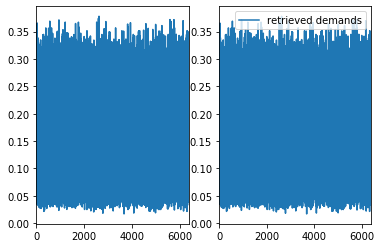

In [54]:
wn = wntr.network.WaterNetworkModel(inp_file)
d_juncs = dict(zip(juncs,df_scaled.columns)) # match each demand node with new demand

# remove old patterns
for name in wn.junction_name_list:
    junc = wn.get_node(name)
    junc.demand_timeseries_list.pop()

print("Removed old patterns")
    
for name in df_scaled.columns:
    wn.add_pattern(name=name, pattern=df_scaled[name].values)

print("Added new patterns")

for name in juncs:
    junc = wn.get_node(name)
    junc.add_demand(1,d_juncs[name])    

print("Added demands")    

# check if demands coincide
df_check = wntr_utils.get_demand_patterns_from_nodes(wn)
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2)
df_scaled.sum(axis=1).plot(ax=axes[0], label = 'loaded demands')
df_check.sum(axis=1).plot(ax=axes[1], label = 'retrieved demands')
plt.legend()

In [55]:
print(wn.options.time.duration)
print(wn.options.time.hydraulic_timestep)

86400
300


In [60]:
# Simulate hydraulics
wn.options.time.duration = 24*3600*7*38
sim_2 = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_2 = sim_2.run_sim()

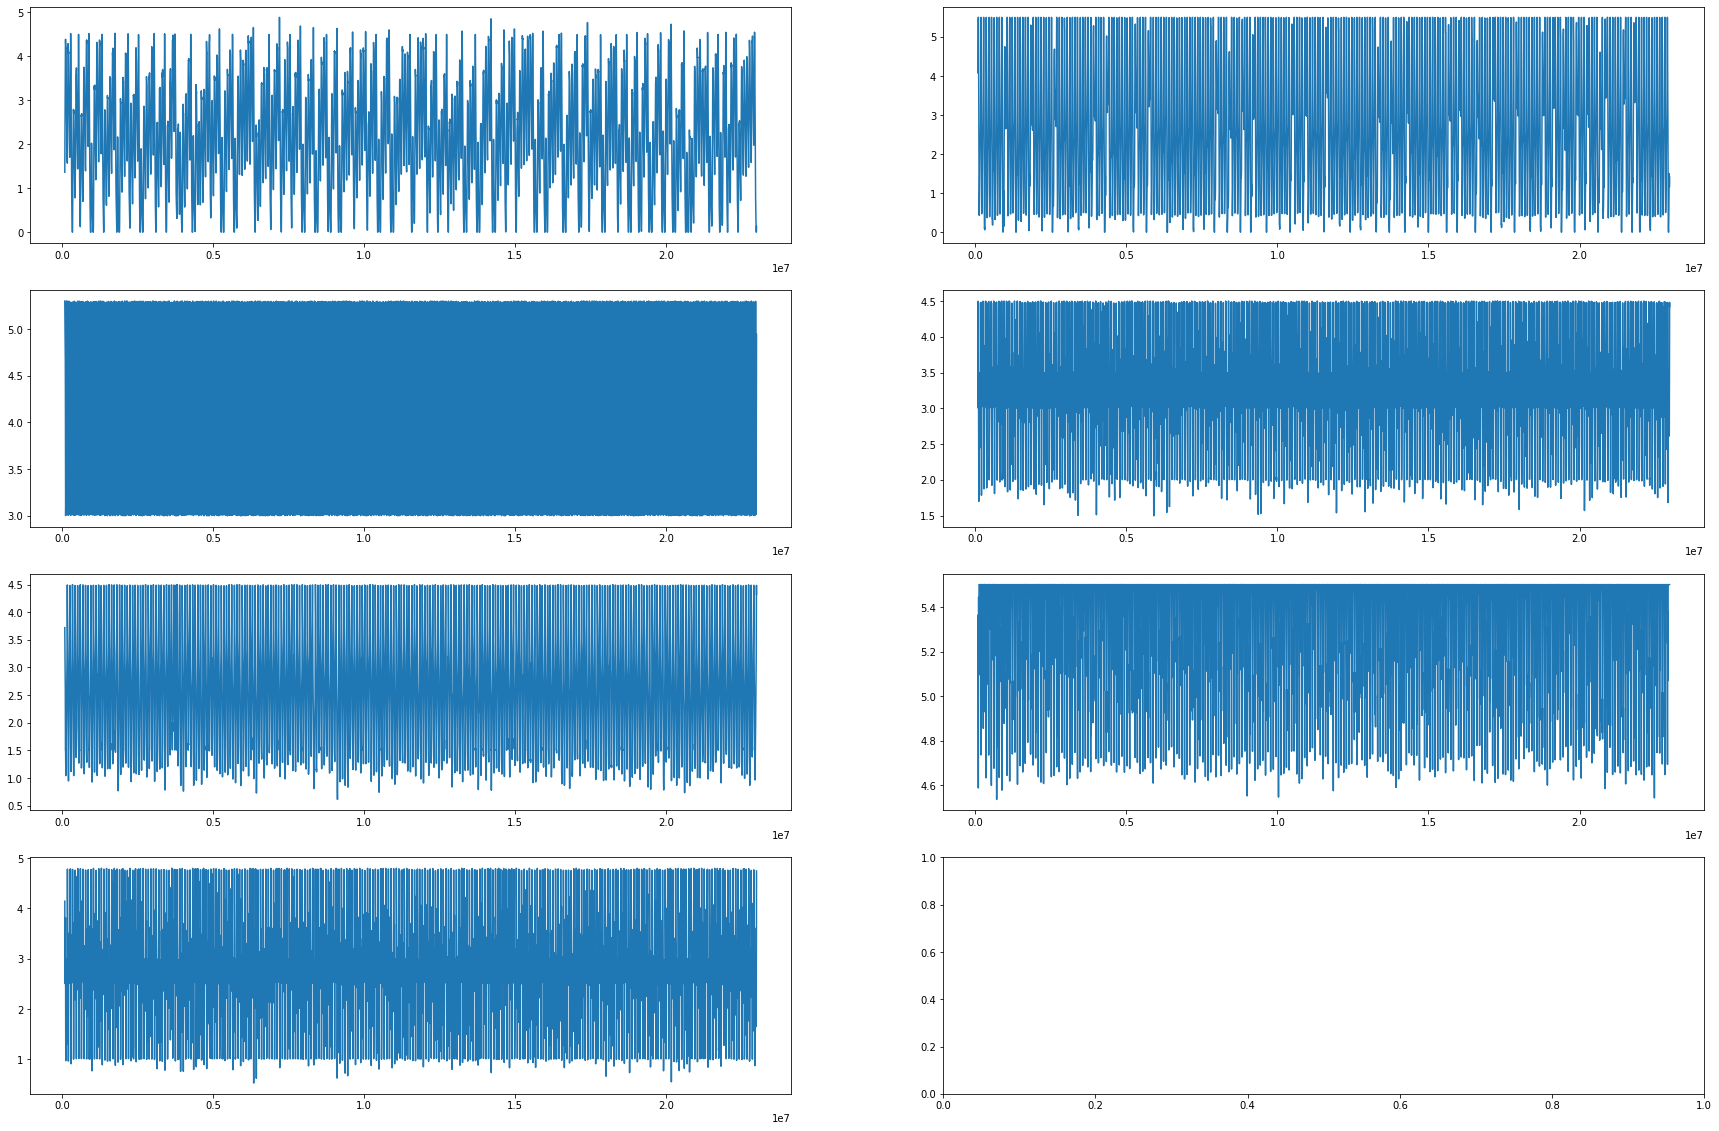

In [64]:
nr = 4
nc = 2
f, ax = plt.subplots(nr,nc,figsize=(30,20))
ax[0][0].plot(results_2.node['pressure']['T1'])
ax[0][1].plot(results_2.node['pressure']['T2'])
ax[1][0].plot(results_2.node['pressure']['T3'])
ax[1][1].plot(results_2.node['pressure']['T4'])
ax[2][0].plot(results_2.node['pressure']['T5'])
ax[2][1].plot(results_2.node['pressure']['T6'])
ax[3][0].plot(results_2.node['pressure']['T7'])

In [74]:
pressure_results = results_2.node['pressure']
pressure_results.to_csv('ctown_9_months.csv')

In [65]:
results_2.node['pressure']['T1']

86700       1.364541
87000       1.395734
87300       1.426947
87600       1.458181
87900       1.489436
              ...   
22981200    0.063340
22981500    0.078292
22981800    0.093238
22982100    0.109289
22982400    0.127571
Name: T1, Length: 76320, dtype: float64

Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error e

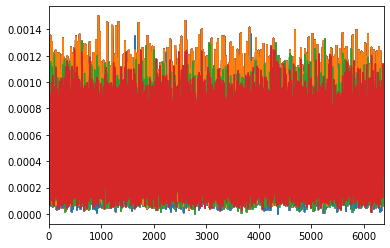

In [63]:
wntr_utils.get_demand_patterns_from_nodes(wn).plot(legend=None)